<a href="https://colab.research.google.com/github/tsakailab/sandbox/blob/master/%5Bdraft%5Ddemo_stable_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# install requirements

In [124]:
!pip install diffusers["torch"]
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## official tutorial

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

StableDiffusionPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=512x512 at 0x7FA824026EE0>], nsfw_content_detected=[False])


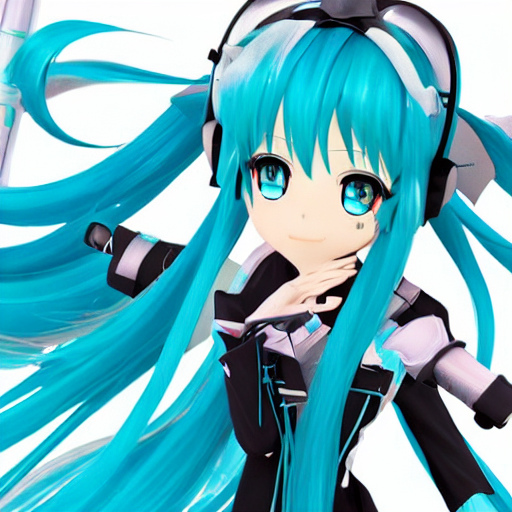

In [125]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "andite/anything-v4.0" # anime
model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

generator = torch.Generator("cuda").manual_seed(1024)

prompt = "hatsune_miku"
image = pipe(prompt, generator=generator)

print(image)
image.images[0]

# How does model predict images?

https://github.com/huggingface/diffusers/blob/d0f258206d9cdcfb8685447d18b6881aed63143e/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L524

## build a model and set prompt

In [1]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "andite/anything-v4.0" # anime
model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

prompt = "hatsune_miku"
generator = torch.Generator("cuda").manual_seed(1024)

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


## run forward

In [4]:
with torch.no_grad():
    # 3. Encode input prompt
    token = pipe.tokenizer(prompt,
                    truncation=True,
                    return_tensors="pt",)
    text_input_ids = token.input_ids.cuda()
    untruncated_ids = pipe.tokenizer(prompt, padding="longest", return_tensors="pt").input_ids
    prompt_embeds = pipe.text_encoder(
        text_input_ids,
        attention_mask=token.attention_mask.cuda(),
    )
    prompt_embeds = prompt_embeds[0]
    bs_embed, seq_len, _ = prompt_embeds.shape
    # duplicate text embeddings for each generation per prompt, using mps friendly method
    prompt_embeds = prompt_embeds.repeat(1, 1, 1)
    prompt_embeds = prompt_embeds.view(bs_embed * 1, seq_len, -1)

    # 4. Prepare timesteps
    pipe.scheduler.set_timesteps(20, device="cuda")
    timesteps = pipe.scheduler.timesteps

    # 5. Prepare latent variables
    device = pipe._execution_device
    num_channels_latents = pipe.unet.config.in_channels
    latents = pipe.prepare_latents(
        1 * 1,
        num_channels_latents,
        512,
        512,
        prompt_embeds.dtype,
        device,
        generator,
        None,
    )

    # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
    extra_step_kwargs = pipe.prepare_extra_step_kwargs(generator, 0.0)

    # 7. Denoising loop
    num_warmup_steps = len(timesteps) - 20 * pipe.scheduler.order
    with pipe.progress_bar(total=20) as progress_bar:
        for i, t in enumerate(timesteps):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = latents
            latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            noise_pred = pipe.unet(
                latent_model_input,
                t,
                encoder_hidden_states=prompt_embeds,
                cross_attention_kwargs=None,
            ).sample

            # compute the previous noisy sample x_t -> x_t-1
            latents = pipe.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

            # call the callback, if provided
            if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % pipe.scheduler.order == 0):
                progress_bar.update()
    # 8. Post-processing
    image = pipe.decode_latents(latents)

    # 9. Run safety checker
    image, has_nsfw_concept = pipe.run_safety_checker(image, device, prompt_embeds.dtype)

  0%|          | 0/20 [00:00<?, ?it/s]